In [146]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import sys
sys.path.append('..')

import torch
import matplotlib.pyplot as plt
from src import models, data
from tqdm.auto import tqdm
import json
import os
import numpy as np
import copy

os.makedirs("layer_sweep/Jacobian_plots", exist_ok=True)
os.makedirs("layer_sweep/weights_and_biases", exist_ok=True)

In [19]:
device = "cuda:0"
mt = models.load_model("gptj", device=device)
print(
    f"dtype: {mt.model.dtype}, device: {mt.model.device}, memory: {mt.model.get_memory_footprint()}"
)

dtype: torch.float16, device: cuda:0, memory: 12219206136


In [ ]:
dataset = data.load_dataset()
cur_relation =[d for d in dataset if d.name == "country capital city"][0]
print(cur_relation)
# capital_cities.__dict__.keys()
len(cur_relation.samples)

In [ ]:
indices = np.random.choice(range(len(cur_relation.samples)), 3, replace=False)
samples = [cur_relation.samples[i] for i in indices]

training_samples = copy.deepcopy(cur_relation.__dict__)
training_samples["samples"] = samples
training_samples = data.Relation(**training_samples)

training_samples.samples

In [ ]:
from src.operators import JacobianIclMeanEstimator

mean_estimator = JacobianIclMeanEstimator(
    mt=mt,
    h_layer=12,
    bias_scale_factor=0.2       # so that the bias doesn't knock out the prediction too much in the direction of training examples
) 

operator = mean_estimator(training_samples)
operator("United States", k = 10).predictions

In [ ]:
from src.data import RelationDataset
from src.benchmarks import reconstruction, faithfulness

In [ ]:
faith_result = faithfulness(
    estimator=mean_estimator,
    dataset = RelationDataset([cur_relation]),
    n_train=3,
    n_trials=5,
    k=3
)

In [ ]:
faith_result.metrics.__dict__

In [ ]:
from src.lens import interpret_logits, logit_lens, _untuple

prompt = "The Space Needle is located in the city of"
tokenized = mt.tokenizer(prompt, return_tensors="pt", padding=True).to(mt.model.device)

import baukit

with baukit.TraceDict(
    mt.model,
    models.determine_layer_paths(mt)
) as traces:
    output = mt.model(**tokenized)
    
interpret_logits(mt, output.logits[0][-1])

In [ ]:
interested_words = [" Seattle", " Paris", " Dhaka"]
int_tokenized = mt.tokenizer(interested_words, return_tensors="pt", padding=True).to(
    mt.model.device
)
int_tokenized.input_ids

z = _untuple(traces[models.determine_layer_paths(mt)[-1]].output)[0][-1]
print(z.shape)

logit_lens(mt, z, [t[0] for t in int_tokenized.input_ids], get_proba=False)

In [ ]:
from src.functional import predict_next_token

predict_next_token(
    mt = mt, prompt = "The Space Needle is located in the city of", k=10
)

In [ ]:
def filter_by_model_knowledge(mt, relation_prompt, relation_samples):
    model_knows = []
    for sample in relation_samples:
        top_prediction = predict_next_token(mt = mt, prompt = relation_prompt.format(sample.subject))[0][0].token
        tick = sample.object.strip().startswith(top_prediction.strip())
        if tick:
            model_knows.append(sample)
    return model_knows

In [ ]:
import numpy as np
from src.functional import make_prompt

icl_indices = np.random.choice(range(len(cur_relation.samples)), 3, replace=False)
icl_samples = [cur_relation.samples[i] for i in icl_indices]

icl_prompt = make_prompt(
    prompt_template = cur_relation.prompt_templates[0],
    subject="{}",
    examples=icl_samples,
)

print(icl_prompt)

In [ ]:
model_knows = filter_by_model_knowledge(mt, icl_prompt, cur_relation.samples)
len(model_knows)

## Layer Richness based on logit lens

In [ ]:
from src.lens import layer_c_measure

# relation_prompt = mt.tokenizer.eos_token + " {} is located in the city of"
# subject = "The Space Needle"
# layer_c_measure(mt, relation_prompt, subject, measure = "contribution", verbose=True)

In [ ]:
c_measure = {layer: [] for layer in models.determine_layer_paths(mt)}

for sample in tqdm(model_knows):
    cur_richness = layer_c_measure(mt, icl_prompt, sample.subject)
    for layer in models.determine_layer_paths(mt):
        c_measure[layer].append(cur_richness[layer])

# with open("layer_sweep/layer_contribution_info.json", "w") as f:
with open("layer_sweep/layer_completeness_info.json", "w") as f:
    json.dump(c_measure, f)

for layer in models.determine_layer_paths(mt):
    c_measure[layer] = np.array(c_measure[layer])

In [ ]:
mean_richness = [c_measure[layer].mean() for layer in models.determine_layer_paths(mt)]
low_richness = [c_measure[layer].min() for layer in models.determine_layer_paths(mt)]
high_richness = [c_measure[layer].max() for layer in models.determine_layer_paths(mt)]

plt.plot(mean_richness, color="blue")
plt.fill_between(range(len(mean_richness)), low_richness, high_richness, alpha=0.2)
plt.axhline(0, color="red", linestyle="--")

plt.xlabel("Layer")
plt.ylabel("completeness")
plt.xticks(range(0, len(mean_richness), 2))

plt.show()

## Layer Richness based on `Jh_norm` and `J_norm`

In [ ]:
import copy

cur_relation_known = copy.deepcopy(cur_relation.__dict__)
cur_relation_known["samples"] = model_knows

cur_relation_known = data.Relation(**cur_relation_known)

In [ ]:
from src.operators import JacobianEstimator, JacobianIclMeanEstimator
from src.data import RelationSample

# indices = np.random.choice(range(len(capital_cities.samples)), 3, replace=False)
# samples = [capital_cities.samples[i] for i in indices]

# training_samples = copy.deepcopy(capital_cities.__dict__)
# training_samples["samples"] = samples
# training_samples = data.Relation(**training_samples)

# mean_estimator = JacobianIclMeanEstimator(
#     mt=mt,
#     h_layer=12,
# )

# operator = mean_estimator(training_samples)
# operator("Russia", k = 10).predictions

In [ ]:
estimator = JacobianEstimator(
    mt=mt,
    h_layer=12,
)

operator = estimator.estimate_for_subject(
    subject = "United States",
    prompt_template= icl_prompt
)

In [ ]:
operator.metadata['Jh'].norm().item(), operator.weight.norm().item()

In [ ]:
layerwise_jh = {layer: [] for layer in models.determine_layer_paths(mt)}

for sample in tqdm(set(model_knows) - set(icl_samples)):
    for h_layer in range(0, 24):
        layer_name = models.determine_layer_paths(mt)[h_layer]
        estimator = JacobianEstimator(
            mt=mt,
            h_layer=h_layer,
        )
        operator = estimator.estimate_for_subject(
            # subject = "Russia",
            subject = sample.subject,
            prompt_template= icl_prompt
        )

        # print(h_layer, " ===> ", f"J:{operator.weight.norm().item()},  Jh: {operator.misc['Jh'].norm().item()}")
        layerwise_jh[layer_name].append({
            "J": operator.weight.norm().item(),
            "Jh": operator.metadata['Jh'].norm().item(),
            "bias": operator.bias.norm().item()
        })

In [ ]:
for layer in models.determine_layer_paths(mt):
    if layer in layerwise_jh and len(layerwise_jh[layer]) == 0:
        layerwise_jh.pop(layer)

with open("layer_sweep/layer_jh_info.json", "w") as f:
    json.dump(layerwise_jh, f)

In [ ]:
key = "Jh"

info = {
    layer: np.array([layerwise_jh[layer][i][key] for i in range(len(layerwise_jh[layer]))])
    for layer in layerwise_jh.keys()
}

mean = [info[layer].mean() for layer in info.keys()]
plt.plot(mean, color="blue", linewidth=4)
plt.xticks(range(0, len(mean), 2))
plt.ylabel(f"{key}_norm")

for i in range(len(set(model_knows) - set(icl_samples))):
    arr = []
    for layer in layerwise_jh.keys():
        arr.append(layerwise_jh[layer][i][key])
    plt.plot(arr, alpha=0.2)

plt.show()

## Causal Tracing on `subject_last`

In [ ]:
from src.lens import causal_tracing

In [ ]:
causal_tracing(
    mt,
    prompt_template = "The location of {} is in the city of",
    subject_original = "The Space Needle",
    subject_corruption = "The Statue of Liberty",
    # verbose = True
)

In [ ]:
import copy

cur_relation_known = copy.deepcopy(cur_relation.__dict__)
cur_relation_known["samples"] = model_knows

cur_relation_known = data.Relation(**cur_relation_known)

In [ ]:
num_icl = 3

icl_indices = np.random.choice(range(len(cur_relation_known.samples)), num_icl, replace=False)
icl_samples = [cur_relation.samples[i] for i in icl_indices]
icl_prompt = [
    f"{cur_relation.prompt_templates[0].format(sample.subject)} {sample.object}"
    for sample in icl_samples
]
icl_prompt = "\n".join(icl_prompt) + "\n" + cur_relation.prompt_templates[0]

print(icl_prompt)

In [ ]:
test_samples = set(cur_relation_known.samples) - set(icl_samples)
causal_tracing_results = {layer: [] for layer in models.determine_layer_paths(mt)}

n_runs = 20
for run in tqdm(range(n_runs)):
    sample_pair = np.random.choice(range(len(test_samples)), 2, replace=False)
    sample_pair = [list(test_samples)[i] for i in sample_pair]
    print(sample_pair)
    
    cur_result = causal_tracing(
        mt,
        prompt_template = icl_prompt,
        subject_original = sample_pair[0].subject,
        subject_corruption = sample_pair[1].subject,
        verbose = False
    )

    for layer in models.determine_layer_paths(mt):
        causal_tracing_results[layer].append(cur_result[layer])

In [ ]:
with open("layer_sweep/causal_tracing_results.json", "w") as f:
    json.dump(causal_tracing_results, f)

for layer in models.determine_layer_paths(mt):
    causal_tracing_results[layer] = np.array(causal_tracing_results[layer])

In [ ]:
models.determine_layers(mt)[::2]

In [ ]:
mean = [causal_tracing_results[layer].mean() for layer in models.determine_layer_paths(mt)]
# low = [causal_tracing_results[layer].min() for layer in mt.layer_names]
# high = [causal_tracing_results[layer].max() for layer in mt.layer_names]

plt.plot(mean, color="blue", linewidth=3)
# plt.fill_between(range(len(mean)), low, high, alpha=0.2)
plt.axhline(0, color="red", linestyle="--")

plt.xlabel("Layer")
plt.ylabel("layer_score")
plt.xticks(models.determine_layers(mt)[::2])

for run in range(n_runs):
    arr = []
    for layer in models.determine_layer_paths(mt):
        arr.append(causal_tracing_results[layer][run])
    plt.plot(arr, alpha=0.2)


plt.show()

## Layer sweep on mean ICL

In [ ]:
import copy

cur_relation_known = copy.deepcopy(cur_relation.__dict__)
cur_relation_known["samples"] = model_knows

cur_relation_known = data.Relation(**cur_relation_known)

In [ ]:
indices = np.random.choice(range(len(cur_relation_known.samples)), 2, replace=False)
samples = [cur_relation_known.samples[i] for i in indices]

capital_cities_subset = copy.deepcopy(cur_relation.__dict__)
capital_cities_subset["samples"] = samples
capital_cities_subset = data.Relation(**capital_cities_subset)

len(capital_cities_subset.samples)

In [ ]:
from src.operators import JacobianIclMeanEstimator

mean_estimator = JacobianIclMeanEstimator(
    mt=mt,
    h_layer=12,
)

operator = mean_estimator(capital_cities_subset)

In [ ]:
operator("Chile", k = 10).predictions

In [ ]:
predictions = []
target = []

for sample in tqdm(set(cur_relation_known.samples)):
    cur_predictions = operator(sample.subject, k = 5).predictions
    predictions.append([
        p.token for p in cur_predictions
    ])
    target.append(sample.object)

In [ ]:
from src.metrics import recall

recall(predictions, target)

In [ ]:
# np.savez("layer_sweep/operator_weight.npz", jacobian = operator.weight.detach().cpu().numpy(), allow_pickle=True)

In [ ]:
# j = np.load("layer_sweep/operator_weight.npz", allow_pickle=True)["jacobian"]

In [ ]:
# torch.dist(torch.tensor(j).to(device), operator.weight)

In [ ]:
def get_layer_wise_recall(capital_cities_subset, verbose = True, save_weights = True):

    layer_wise_recall = {}

    layer_names = models.determine_layer_paths(mt)
    for h_layer in tqdm(range(0, 24)):
        layer_name = layer_names[h_layer]
        mean_estimator = JacobianIclMeanEstimator(
            mt=mt,
            h_layer=h_layer,
        )
        operator = mean_estimator(capital_cities_subset)
        if(save_weights):
            np.savez(
                f"layer_sweep/weights_and_biases/{layer_name}.npz", 
                jacobian = operator.weight.detach().cpu().numpy(),
                bias = operator.bias.detach().cpu().numpy(), 
                allow_pickle=True
            )

        predictions = []
        target = []

        for sample in set(cur_relation_known.samples) - set(capital_cities_subset.samples):
            cur_predictions = operator(sample.subject, k = 5).predictions
            predictions.append([
                p.token for p in cur_predictions
            ])
            target.append(sample.object)

        layer_wise_recall[layer_name] = recall(predictions, target)
        
        if(verbose):
            print(layer_name, layer_wise_recall[layer_name])
    
    return layer_wise_recall

layer_wise_recall = get_layer_wise_recall(capital_cities_subset, verbose = True, save_weights = True)

In [ ]:
with open("layer_sweep/layer_wise_recall.json", "w") as f:
    json.dump(layer_wise_recall, f)

In [ ]:
faithfulness_result = {}
number_of_runs = 10

for run in tqdm(range(number_of_runs)):
    indices = np.random.choice(range(len(cur_relation_known.samples)), 2, replace=False)
    samples = [cur_relation_known.samples[i] for i in indices]

    capital_cities_subset = copy.deepcopy(cur_relation.__dict__)
    capital_cities_subset["samples"] = samples
    capital_cities_subset = data.Relation(**capital_cities_subset)

    layer_wise_recall = get_layer_wise_recall(capital_cities_subset, verbose=False, save_weights=False)

    for layer in layer_wise_recall.keys():
        if(layer not in faithfulness_result):
            faithfulness_result[layer] = []
        faithfulness_result[layer].append(layer_wise_recall[layer])

In [ ]:
with open("layer_sweep/layer_wise_recall_collection.json", "w") as f:
    json.dump(faithfulness_result, f)

In [ ]:
with open("layer_sweep/layer_wise_recall_collection.json") as f:
    faithfulness_result = json.load(f)

In [ ]:
# top_1 = [layer_wise_recall[layer][0] for layer in layer_wise_recall.keys()]
# top_2 = [layer_wise_recall[layer][1] for layer in layer_wise_recall.keys()]
# top_3 = [layer_wise_recall[layer][2] for layer in layer_wise_recall.keys()]

import numpy as np

top_1 = np.array([
    np.array(faithfulness_result[layer])[:, 0]
    for layer in faithfulness_result.keys()
])

top_2 = np.array([
    np.array(faithfulness_result[layer])[:, 1]
    for layer in faithfulness_result.keys()
])

top_3 = np.array([
    np.array(faithfulness_result[layer])[:, 2]
    for layer in faithfulness_result.keys()
])


plt.plot(top_1.mean(axis=1), color="green", linewidth=3, label="recall@1")
plt.plot(top_2.mean(axis=1), color="blue", linewidth=2, label="recall@2")
plt.plot(top_3.mean(axis=1), color="red", linewidth=1, label="recall@3")

plt.fill_between(
    range(len(faithfulness_result.keys())),
    top_1.min(axis=1), top_1.max(axis=1),
    color="green", alpha=0.1
)

plt.fill_between(
    range(len(faithfulness_result.keys())),
    top_2.min(axis=1), top_2.max(axis=1),
    color="blue", alpha=0.05
)

plt.fill_between(
    range(len(faithfulness_result.keys())),
    top_3.min(axis=1), top_3.max(axis=1),
    color="red", alpha=0.03
)


plt.xticks(range(0, len(top_1), 2))
plt.xlabel("layer")
plt.ylabel("recall")

plt.legend()
plt.show()

In [ ]:
from src.utils.viz_utils import matrix_heatmap

for layer_name in models.determine_layer_paths(mt)[:24]:
    j = np.load(f"layer_sweep/weights_and_biases/{layer_name}.npz", allow_pickle=True)["jacobian"]
    j = torch.tensor(j).to(device)
    print(layer_name, j.shape)
    matrix_heatmap(j, title = layer_name, save_path=f"layer_sweep/Jacobian_plots/{layer_name}.png")

## Plotting

In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
results_dir = "../results/layer_sweep/gptj"
os.listdir(results_dir)

['work location.json',
 'outside color of fruits and vegetables.json',
 'word comparative.json',
 'name religion.json',
 'plays pro sport.json',
 'person superhero name.json',
 'occupation.json',
 'country capital city.json',
 'landmark in country.json',
 'word past tense.json',
 'task done by person NEEDS REVISION.json',
 'name gender.json']

In [4]:
relation_name = "plays pro sport"
with open(f"{results_dir}/{relation_name}.json") as f:
    cur_relation = json.load(f)

In [5]:
def plot_c_measure(c_measure, measure ,title):
    for layer in c_measure.keys():
        c_measure[layer] = np.array(c_measure[layer])

    mean_richness = [c_measure[layer].mean() for layer in c_measure.keys()]
    low_richness = [c_measure[layer].min() for layer in c_measure.keys()]
    high_richness = [c_measure[layer].max() for layer in c_measure.keys()]

    plt.plot(mean_richness, color="blue")
    plt.fill_between(range(len(mean_richness)), low_richness, high_richness, alpha=0.2)
    plt.axhline(0, color="red", linestyle="--")

    plt.xlabel("Layer")
    plt.ylabel(measure)
    plt.xticks(range(0, len(mean_richness), 2))
    plt.title(title)
    return plt

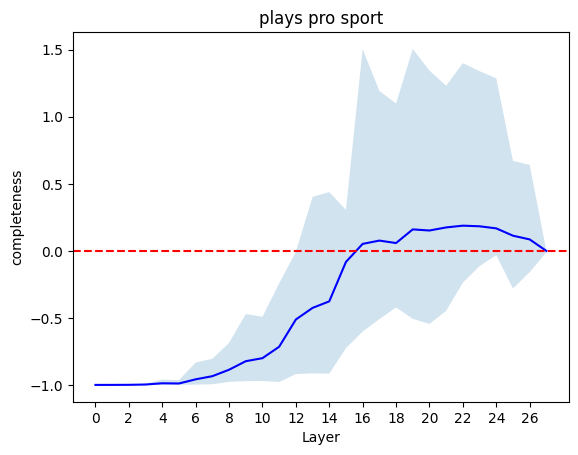

In [6]:
plot_c_measure(cur_relation['layer_completeness'], measure="completeness", title=relation_name).show()

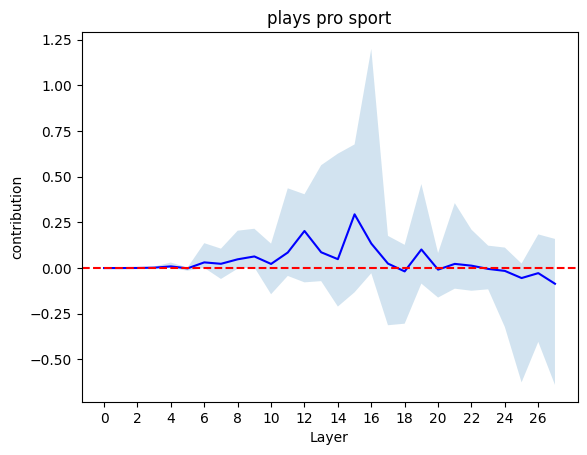

In [7]:
plot_c_measure(cur_relation['layer_contributions'], measure="contribution", title=relation_name).show()

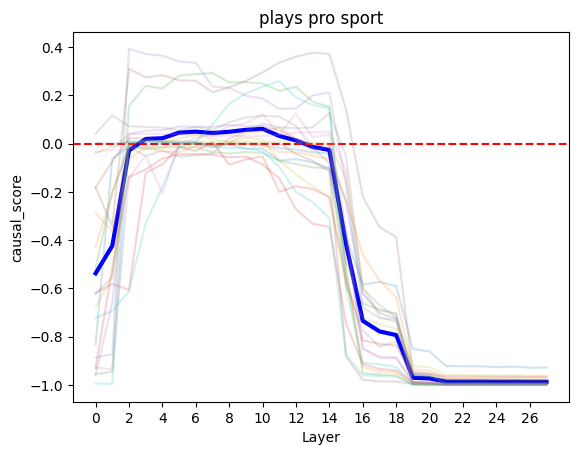

In [8]:
def plot_layer_wise_causal_tracing(causal_tracing_results, title):
    for layer in causal_tracing_results.keys():
        causal_tracing_results[layer] = np.array(causal_tracing_results[layer])
    mean = [causal_tracing_results[layer].mean() for layer in causal_tracing_results.keys()]
    # low = [causal_tracing_results[layer].min() for layer in mt.layer_names]
    # high = [causal_tracing_results[layer].max() for layer in mt.layer_names]

    plt.plot(mean, color="blue", linewidth=3)
    # plt.fill_between(range(len(mean)), low, high, alpha=0.2)
    plt.axhline(0, color="red", linestyle="--")

    plt.xlabel("Layer")
    plt.ylabel("causal_score")
    plt.xticks(range(len(causal_tracing_results.keys()))[::2])
    plt.title(title)

    nrun = causal_tracing_results[list(causal_tracing_results.keys())[0]].shape[0]
    for run in range(nrun):
        arr = []
        for layer in causal_tracing_results.keys():
            arr.append(causal_tracing_results[layer][run])
        plt.plot(arr, alpha=0.2)
    return plt

plot_layer_wise_causal_tracing(cur_relation['causal_tracing'], title = relation_name).show()

In [9]:
faithfulness_result = {
    layer: faith["recall_lre_if_lm_correct"]
    for layer, faith in cur_relation["faithfulness"].items()
}

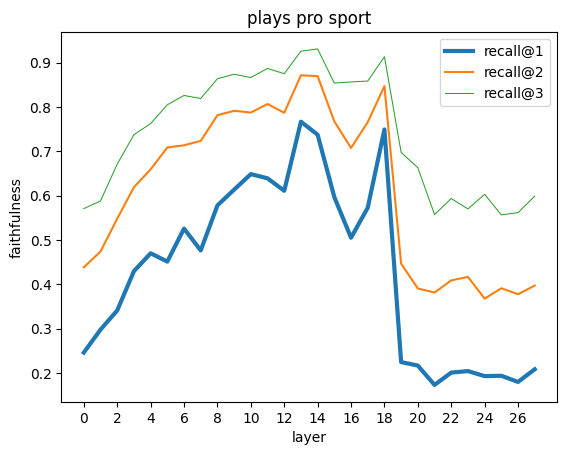

In [10]:
def plot_layer_wise_faithfulness(faithfulness_result, title, recall_upto = 3):
    linewidth = 3
    for recall_at in range(recall_upto):
        result = np.array([
            np.array(faithfulness_result[layer])[recall_at]
            for layer in faithfulness_result.keys()
        ])
        plt.plot(result, linewidth=linewidth, label=f"recall@{recall_at + 1}")
        linewidth /= 2

    plt.xticks(range(0, len(result), 2))
    plt.xlabel("layer")
    plt.ylabel("faithfulness")
    plt.legend()
    plt.title(title)

    return plt

plot_layer_wise_faithfulness(faithfulness_result, title=relation_name).show()

## Finalizing `select_layer` Algo

In [30]:
from src import data

dataset = data.load_dataset()
cur_relation =[d for d in dataset if d.name == "plays pro sport"][0]
print(cur_relation)
len(cur_relation.samples)

Relation(name='plays pro sport', prompt_templates=['{} plays the sport of', 'What sport does {} play? They play', '{} plays professionally in the sport of'], samples=[RelationSample(subject='Andreas Ivanschitz', object='soccer'), RelationSample(subject='Roberto Clemente', object='baseball'), RelationSample(subject='Carlos Valderrama', object='soccer'), RelationSample(subject='Hank Aaron', object='baseball'), RelationSample(subject='Jari Kurri', object='hockey'), RelationSample(subject='Zdeno Chára', object='hockey'), RelationSample(subject='David Carney', object='soccer'), RelationSample(subject='Peter Šťastný', object='hockey'), RelationSample(subject='R.A. Dickey', object='baseball'), RelationSample(subject='Luis Scola', object='basketball'), RelationSample(subject='Satchel Paige', object='baseball'), RelationSample(subject='Elton Brand', object='basketball'), RelationSample(subject='Terrell Owens', object='football'), RelationSample(subject='Matteo Ferrari', object='soccer'), Relati

318

In [41]:
indices = np.random.choice(range(len(cur_relation.samples)), 20, replace=False)
samples = [cur_relation.samples[i] for i in indices]

training_samples = copy.deepcopy(cur_relation.__dict__)
training_samples["samples"] = samples
training_samples = data.Relation(**training_samples)

training_samples.samples

[RelationSample(subject='David Andersen', object='basketball'),
 RelationSample(subject='Michael Bradley', object='soccer'),
 RelationSample(subject='Dwyane Wade', object='basketball'),
 RelationSample(subject='Sergei Makarov', object='hockey'),
 RelationSample(subject='Wilt Chamberlain', object='basketball'),
 RelationSample(subject='Bobby Orr', object='hockey'),
 RelationSample(subject='Scottie Pippen', object='basketball'),
 RelationSample(subject='Lawrence Taylor', object='football'),
 RelationSample(subject='Jiří Šlégr', object='hockey'),
 RelationSample(subject='Maurice Richard', object='hockey'),
 RelationSample(subject='Bart Starr', object='football'),
 RelationSample(subject='Stan Mikita', object='hockey'),
 RelationSample(subject='Dan Marino', object='football'),
 RelationSample(subject='Hakeem Olajuwon', object='basketball'),
 RelationSample(subject='Ty Cobb', object='baseball'),
 RelationSample(subject='Dean Cain', object='football'),
 RelationSample(subject='Corey Perry', 

searching for optimal layer: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]

Knee: 11, Elbow: 11


12

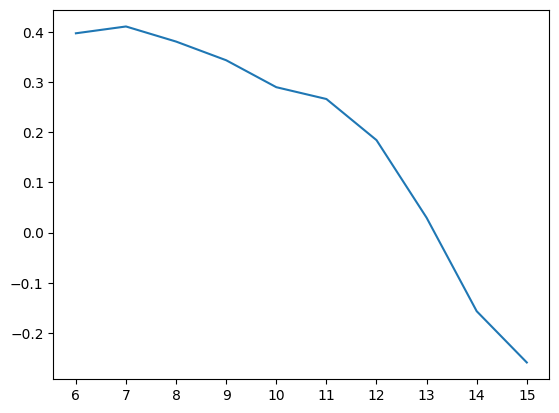

In [62]:
from src.select_hparams import select_layer
select_layer(
    mt = mt,
    training_data = training_samples,
    verbose=True
)

In [49]:
from h_param_sweep.layer_sweep import filter_by_model_knowledge, choose_sample_pairs
from src.functional import make_prompt
from src.select_hparams import causal_tracing

relation = cur_relation
layer_names = models.determine_layer_paths(mt)

icl_indices = np.random.choice(range(len(relation.samples)), 3, replace=False)
icl_samples = [relation.samples[i] for i in icl_indices]

icl_prompt = make_prompt(
    prompt_template=relation.prompt_templates[0],
    subject="{}",
    examples=icl_samples,
)

relation_known = filter_by_model_knowledge(
    mt, relation_prompt=icl_prompt, relation_samples=relation.samples
)

test_samples = set(relation_known) - set(icl_samples)
causal_tracing_results: dict = {layer: [] for layer in layer_names}

for run in tqdm(range(20)):
    sample_pair = choose_sample_pairs(list(test_samples))
    cur_result = causal_tracing(
        mt,
        prompt_template=icl_prompt,
        subject_original=sample_pair[0].subject,
        subject_corruption=sample_pair[1].subject,
    )

    for layer in layer_names:
        causal_tracing_results[layer].append(cur_result[layer])

  0%|          | 0/20 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x7f1da0119ea0>
Traceback (most recent call last):
  File "/home/local_arnab/miniconda3/envs/relations/lib/python3.10/site-packages/tqdm/std.py", line 1145, in __del__
    self.close()
  File "/home/local_arnab/miniconda3/envs/relations/lib/python3.10/site-packages/tqdm/notebook.py", line 286, in close
    self.disp(bar_style='success', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


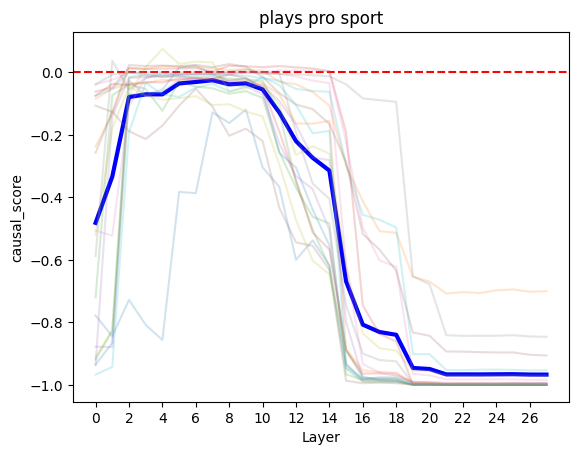

In [51]:
plot_layer_wise_causal_tracing(causal_tracing_results, title = relation_name).show()

## Bias Scale Sweep

In [105]:
results_dir = "../results/layer_sweep/gptj"
sweep_relations = os.listdir(results_dir)

In [107]:
recall_results_collection = {}
bias_scales = None

for relation_result in sweep_relations:
    with open(f"{results_dir}/{relation_result}") as f:
        sweep_results = json.load(f)
        # print(f"{relation_result.split('.')[0]}: {sweep_results['optimal_layer']}")
        # sweep_results = sweep_results['results']
        sweep_results = sweep_results['faithfulness']

        result = np.array([
            sweep_results[bias_scale_factor]['recall_lre_if_lm_correct']
            for bias_scale_factor in sweep_results.keys()
        ])
        if(bias_scales is None):
            bias_scales = list(sweep_results.keys())
            recall_results_collection = {bias_scale_factor: [] for bias_scale_factor in sweep_results.keys()}

        for bias_scale_factor in sweep_results.keys():
            recall_results_collection[bias_scale_factor].append(
                sweep_results[bias_scale_factor]['recall_lre_if_lm_correct']
            )

In [108]:
recall_results_collection.keys()

dict_keys(['transformer.h.0', 'transformer.h.1', 'transformer.h.2', 'transformer.h.3', 'transformer.h.4', 'transformer.h.5', 'transformer.h.6', 'transformer.h.7', 'transformer.h.8', 'transformer.h.9', 'transformer.h.10', 'transformer.h.11', 'transformer.h.12', 'transformer.h.13', 'transformer.h.14', 'transformer.h.15', 'transformer.h.16', 'transformer.h.17', 'transformer.h.18', 'transformer.h.19', 'transformer.h.20', 'transformer.h.21', 'transformer.h.22', 'transformer.h.23', 'transformer.h.24', 'transformer.h.25', 'transformer.h.26', 'transformer.h.27'])

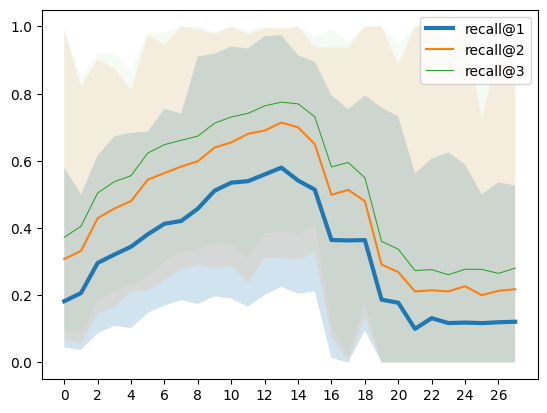

In [114]:
for bias_scale_factor in recall_results_collection.keys():
    recall_results_collection[bias_scale_factor] = np.array(recall_results_collection[bias_scale_factor])
    # print(bias_scale_factor, recall_results_collection[bias_scale_factor].shape)

recall_upto = 3
linewidth = 3
alpha = 0.2
for recall_at in range(recall_upto):
    mean = np.array([
        recall_results_collection[bias_scale_factor][:, recall_at].mean()
        for bias_scale_factor in recall_results_collection.keys()
    ])
    low = np.array([
        recall_results_collection[bias_scale_factor][:, recall_at].min()
        for bias_scale_factor in recall_results_collection.keys()
    ])
    high = np.array([
        recall_results_collection[bias_scale_factor][:, recall_at].max()
        for bias_scale_factor in recall_results_collection.keys()
    ])

    plt.plot(mean, linewidth=linewidth, label=f"recall@{recall_at + 1}")
    plt.fill_between(
        range(len(mean)),
        low,    # lower bound
        high,   # upper bound
        alpha=alpha
    )
    linewidth /= 2
    alpha /= 2
# plt.xticks(
#     range(len(recall_results_collection.keys())), 
#     list(recall_results_collection.keys())
# )

plt.xticks(range(0, len(recall_results_collection.keys()), 2))

plt.legend()
plt.show()

In [116]:
one_key

'transformer.h.0'

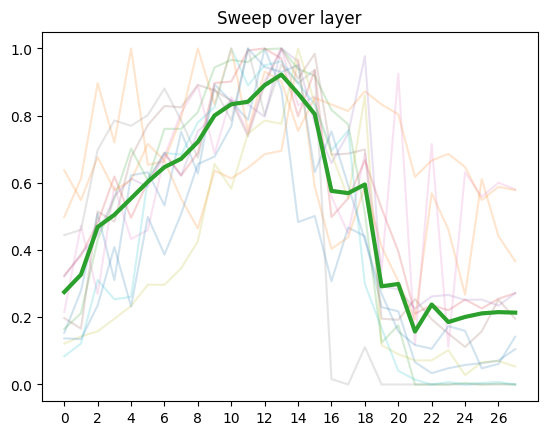

In [117]:
recall_at = 0
one_key = list(recall_results_collection.keys())[0]


all_results = []
for r in range(recall_results_collection[one_key].shape[0]):
    r_result = np.array([
        recall_results_collection[bias_scale_factor][r, recall_at]
        for bias_scale_factor in recall_results_collection.keys()
    ])
    r_result = r_result/r_result.max()
    plt.plot(
        r_result,
        alpha=0.2
    )
    all_results.append(r_result)

all_results = np.array(all_results)
plt.plot(all_results.mean(axis = 0), linewidth=3)
# plt.xticks(range(len(recall_results_collection.keys())), list(recall_results_collection.keys()))

plt.xticks(range(0, len(recall_results_collection.keys()), 2))
plt.title("Sweep over layer")
plt.show()

## Rank Sweep

In [125]:
from src.benchmarks import causality, faithfulness
from h_param_sweep.utils import select_subset_from_relation

In [126]:
max_samples = 200
###################################################
FILTER_RELATIONS: list = [
    # "country capital city",
    # "occupation",
    "person superhero name",
    "plays pro sport",
    "landmark in country",
    "outside color of fruits and vegetables",
    # "work location",
    # "task done by person NEEDS REVISION",
    # "word comparative",
    # "word past tense",
    # "name gender",
    # "name religion",
]
###################################################

In [127]:
dataset = data.load_dataset()
dataset = data.RelationDataset(
    relations=[
        select_subset_from_relation(
            relation = r,
            n = max_samples)  
        for r in dataset.relations if r.name in FILTER_RELATIONS]
)
for d in dataset.relations:
    print(f"{d.name} : {len(d.samples)}")

landmark in country : 200
outside color of fruits and vegetables : 15
plays pro sport : 200
person superhero name : 100


In [128]:
from src.operators import JacobianIclMeanEstimator

mean_estimator = JacobianIclMeanEstimator(
    mt=mt,
    h_layer=13,
    bias_scale_factor=0.4       # so that the bias doesn't knock out the prediction too much in the direction of training examples
) 

In [129]:
faith_result = faithfulness(
    estimator = mean_estimator,
    dataset = dataset,
    n_train = 3,
    n_trials = 5,
    k = 3
)

faithfulness:   0%|          | 0/4 [00:00<?, ?it/s]

In [153]:
from src.editors import LowRankPInvEditor, LinearRelationEditor
editor = LowRankPInvEditor(
    mt = mt, lre = mean_estimator,
    rank = 150, n_tokens=10
)

In [154]:
causality_results = causality(
    estimator= mean_estimator,
    editor_type = LowRankPInvEditor,
    dataset = dataset,
    rank = 150, n_tokens=10
)

causality:   0%|          | 0/4 [00:00<?, ?it/s]

<class 'src.editors.LowRankPInvEditor'>
dict_keys(['rank', 'n_tokens', 'lre'])
 >>  150
<class 'src.editors.LowRankPInvEditor'>
dict_keys(['rank', 'n_tokens', 'lre'])
 >>  150
<class 'src.editors.LowRankPInvEditor'>
dict_keys(['rank', 'n_tokens', 'lre'])
 >>  150
<class 'src.editors.LowRankPInvEditor'>
dict_keys(['rank', 'n_tokens', 'lre'])
 >>  150
<class 'src.editors.LowRankPInvEditor'>
dict_keys(['rank', 'n_tokens', 'lre'])
 >>  150
<class 'src.editors.LowRankPInvEditor'>
dict_keys(['rank', 'n_tokens', 'lre'])
 >>  150
<class 'src.editors.LowRankPInvEditor'>
dict_keys(['rank', 'n_tokens', 'lre'])
 >>  150
<class 'src.editors.LowRankPInvEditor'>
dict_keys(['rank', 'n_tokens', 'lre'])
 >>  150
<class 'src.editors.LowRankPInvEditor'>
dict_keys(['rank', 'n_tokens', 'lre'])
 >>  150
<class 'src.editors.LowRankPInvEditor'>
dict_keys(['rank', 'n_tokens', 'lre'])
 >>  150
<class 'src.editors.LowRankPInvEditor'>
dict_keys(['rank', 'n_tokens', 'lre'])
 >>  150
<class 'src.editors.LowRankPInvE

In [150]:
issubclass(LowRankPInvEditor, LinearRelationEditor)

True

In [158]:
causality_results.metrics.__dict__

{'efficacy_mean': 0.1877022683620453, 'efficacy_std': 0.3906322717666626}